### Importando as bibliotecas necessárias para iniciar a leitura dos arquivos

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

#### Lendo os dados da base tratada de 2018 a 2024

In [2]:
df_accidents = pd.read_csv(
    "../../wrangling/datatran2018_2024_dados_tratados.csv",
    parse_dates=["data_inversa", "mes_ano"]
)
df_accidents.info()
df_accidents.reset_index(drop=True, inplace=True)

/var/folders/z1/3syxl8gd5ks431s8c9n9mrs00000gn/T/ipykernel_45192/3588309097.py:1: DtypeWarning: Columns (22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  df_accidents = pd.read_csv(


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 436643 entries, 0 to 436642
Data columns (total 24 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   id                      436643 non-null  float64       
 1   data_inversa            436643 non-null  datetime64[ns]
 2   tipo_data               436643 non-null  object        
 3   ano                     436643 non-null  int64         
 4   mes                     436643 non-null  int64         
 5   mes_ano                 436643 non-null  datetime64[ns]
 6   dia_semana              436643 non-null  object        
 7   horario                 436643 non-null  object        
 8   fase_dia                436643 non-null  object        
 9   condicao_metereologica  436643 non-null  object        
 10  uf                      436643 non-null  object        
 11  municipio               436643 non-null  object        
 12  br                      436643

#### Criando função para desenhar gráfico de barras à partir de determinados parâmetros

In [ ]:
now = pd.Timestamp.now()


def generate_barplot(
        enable_lineplot,
        x_value,
        y_value,
        title=None,
        x_label=None,
        y_label=None,
        file_name=f'barplot_{pd.Timestamp.now().strftime("%Y%m%d%H%M%S")}'
):
    plt.figure(figsize=(20, 6))
    sns.barplot(x=x_value, y=y_value)
    if enable_lineplot:
        sns.lineplot(x=x_value, y=y_value, marker="o",
                     color="red", linewidth=1)
        plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.title(title)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.xticks(rotation=45, ha="right")
    plt.margins(x=0)
    plt.savefig(f"../../barplot_{file_name}.png")
    plt.show()

#### Cria função para converter os nomes dos meses e a ordem deles

In [4]:
def get_months():
    months = {
        1: "Janeiro",
        2: "Fevereiro",
        3: "Março",
        4: "Abril",
        5: "Maio",
        6: "Junho",
        7: "Julho",
        8: "Agosto",
        9: "Setembro",
        10: "Outubro",
        11: "Novembro",
        12: "Dezembro",
    }
    months_sorted = [
        months[1],
        months[2],
        months[3],
        months[4],
        months[5],
        months[6],
        months[7],
        months[8],
        months[9],
        months[10],
        months[11],
        months[12]
    ]

    return months, months_sorted

#### Análise da distribuição dos acidentes entre os anos de 2018 e 2024

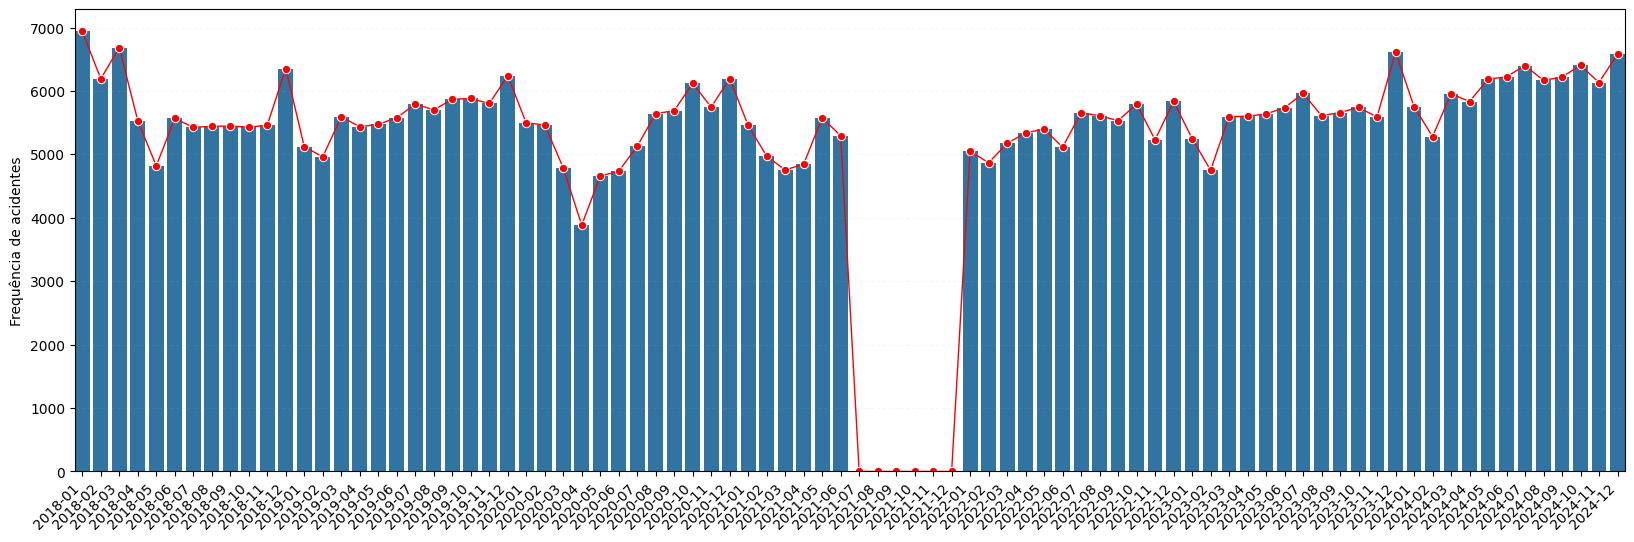

In [5]:
# Criar o intervalo completo de meses para o período desejado (de 2018 até 2024)
date_range = pd.date_range(start=df_accidents['mes_ano'].min(
), end=df_accidents['mes_ano'].max(), freq='MS')

# Agrupar os dados e contar as ocorrências
df_accidents_old = df_accidents["mes_ano"].value_counts().sort_index()

# Ajustar o índice para o formato mês-ano
df_accidents_old.index = df_accidents_old.index.strftime("%Y-%m")

# Garantir que todos os meses do intervalo estejam presentes e atribuir 0 para os que não tiverem ocorrências
df_accidents_old = df_accidents_old.reindex(
    date_range.strftime("%Y-%m"), fill_value=0)

generate_barplot(
    enable_lineplot=True,
    x_value=df_accidents_old.index.astype(str),
    y_value=df_accidents_old.values,
    y_label="Frequência de acidentes",
    file_name="acidentes_por_mes_ano_antes"
)

#### Análise da distribuição dos acidentes por ano

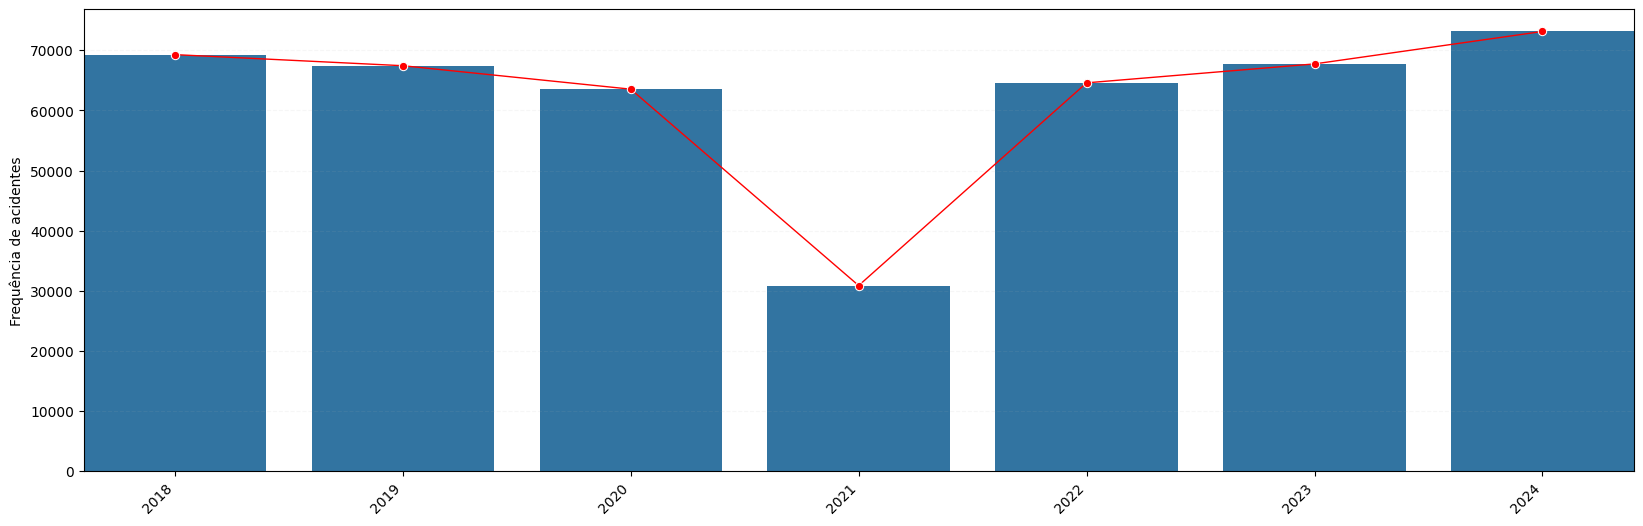

In [6]:
df_accidents_old = df_accidents["ano"].value_counts().sort_index()
df_accidents_old.index = df_accidents_old.index

generate_barplot(
    enable_lineplot=True,
    x_value=df_accidents_old.index.astype(str),
    y_value=df_accidents_old.values,
    y_label="Frequência de acidentes",
    file_name="acidentes_por_ano_antes"
)

#### Análise da distribuição dos acidentes por mês

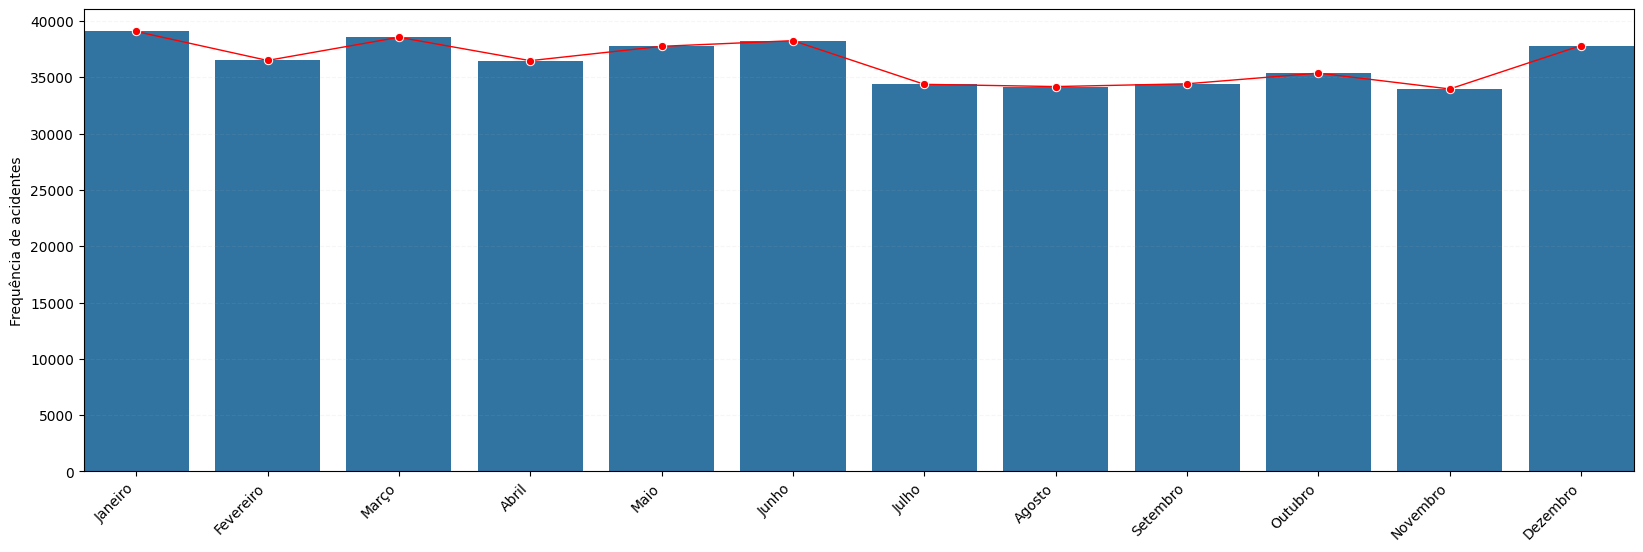

In [7]:
months, months_sorted = get_months()

df_accidents_old = df_accidents["mes"].value_counts().sort_index()
df_accidents_old.index = df_accidents_old.index.map(months)

# Convertendo o índice para categoria com a ordem correta
df_accidents_old.index = pd.Categorical(
    df_accidents_old.index, categories=months_sorted, ordered=True)

generate_barplot(
    enable_lineplot=True,
    x_value=df_accidents_old.index.astype(str),
    y_value=df_accidents_old.values,
    y_label="Frequência de acidentes",
    file_name="acidentes_por_mes_antes"
)

#### Analisando os dados do ano de 2021, foi possível perceber que os meses de julho a dezembro não foram populados. Para não influenciar negativamente nas análises, preencherei esses dados considerando a média ou mediana dos demais anos

In [8]:
# Últimos dias dos meses
end_of_month = dict({7: 31, 8: 31, 9: 30, 10: 31, 11: 30, 12: 31})
reference_years = [2018, 2019, 2020, 2022, 2023, 2024]
occurrences_dict = {}

for month in end_of_month:
    for day in range(1, end_of_month[month] + 1):
        for year in reference_years:
            current_date = f'{year}-{month:02d}-{day:02d}'
            # Contando as ocorrências para cada data
            occurrences_count = df_accidents[df_accidents["data_inversa"] == current_date].shape[0]
            occurrences_dict[current_date] = occurrences_count

        mean = int(np.mean(list(occurrences_dict.values())))

        # Criando novas linhas com 'data_inversa' preenchido e outras colunas como NaN
        novas_linhas = pd.DataFrame({
            'data_inversa': [pd.to_datetime(f'2021-{month:02d}-{day:02d}')] * mean,
            'mes_ano': [pd.to_datetime(f'2021-{month:02d}-{day:02d}')] * mean,
            'mes': [int(f'{month:02d}')] * mean,
            'ano': [2021] * mean,
        })

        # Adicionando as outras colunas, preenchendo com NaN
        for col in df_accidents.columns:
            if col not in ('data_inversa', 'mes_ano', 'mes', 'ano'):
                novas_linhas[col] = np.nan

        # Concatenando as novas linhas no DataFrame existente
        df_accidents = pd.concat(
            [df_accidents, novas_linhas], ignore_index=True)

df_accidents["mes_ano"] = df_accidents["data_inversa"].dt.to_period("M")
df_accidents.to_csv(
    "../../wrangling/datatran2018_2024_dados_tratados_v2.csv", index=False)

#### Análise da distribuição dos acidentes entre os anos de 2018 e 2024 (após o tratamento de 2021)

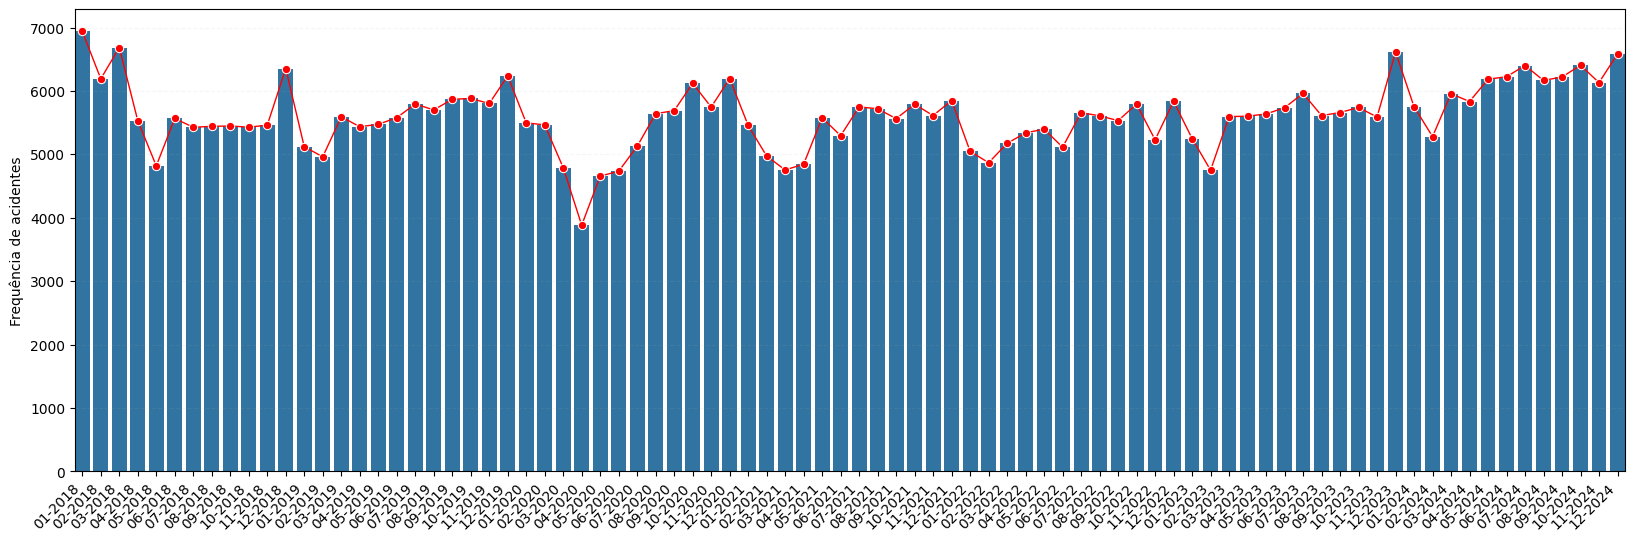

In [9]:
df_accidents_new = df_accidents["mes_ano"].value_counts().sort_index()

df_accidents_new.index = df_accidents_new.index.strftime("%m-%Y")

generate_barplot(
    enable_lineplot=True,
    x_value=df_accidents_new.index.astype(str),
    y_value=df_accidents_new.values,
    y_label="Frequência de acidentes",
    file_name="acidentes_por_mes_ano_depois"
)

#### Análise da distribuição dos acidentes por ano

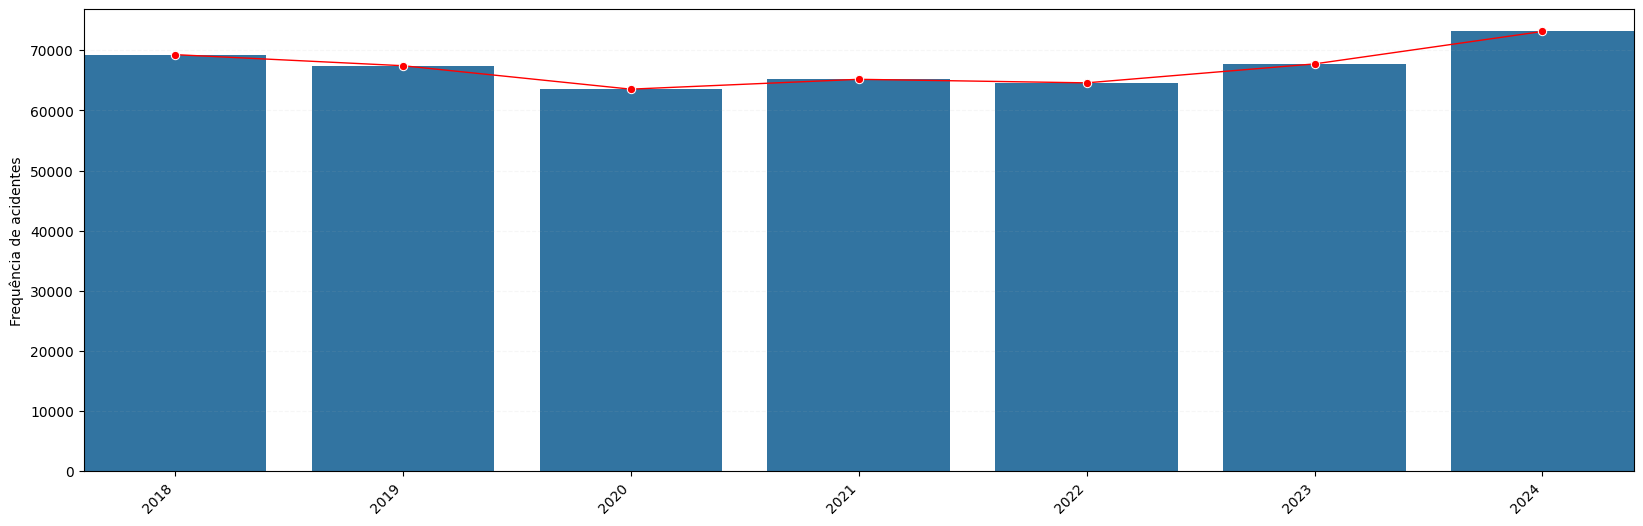

In [10]:
df_accidents_new = df_accidents["ano"].value_counts().sort_index()
df_accidents_new.index = df_accidents_new.index

generate_barplot(
    enable_lineplot=True,
    x_value=df_accidents_new.index.astype(str),
    y_value=df_accidents_new.values,
    y_label="Frequência de acidentes",
    file_name="acidentes_por_ano_depois"
)

#### Análise da distribuição dos acidentes por mês

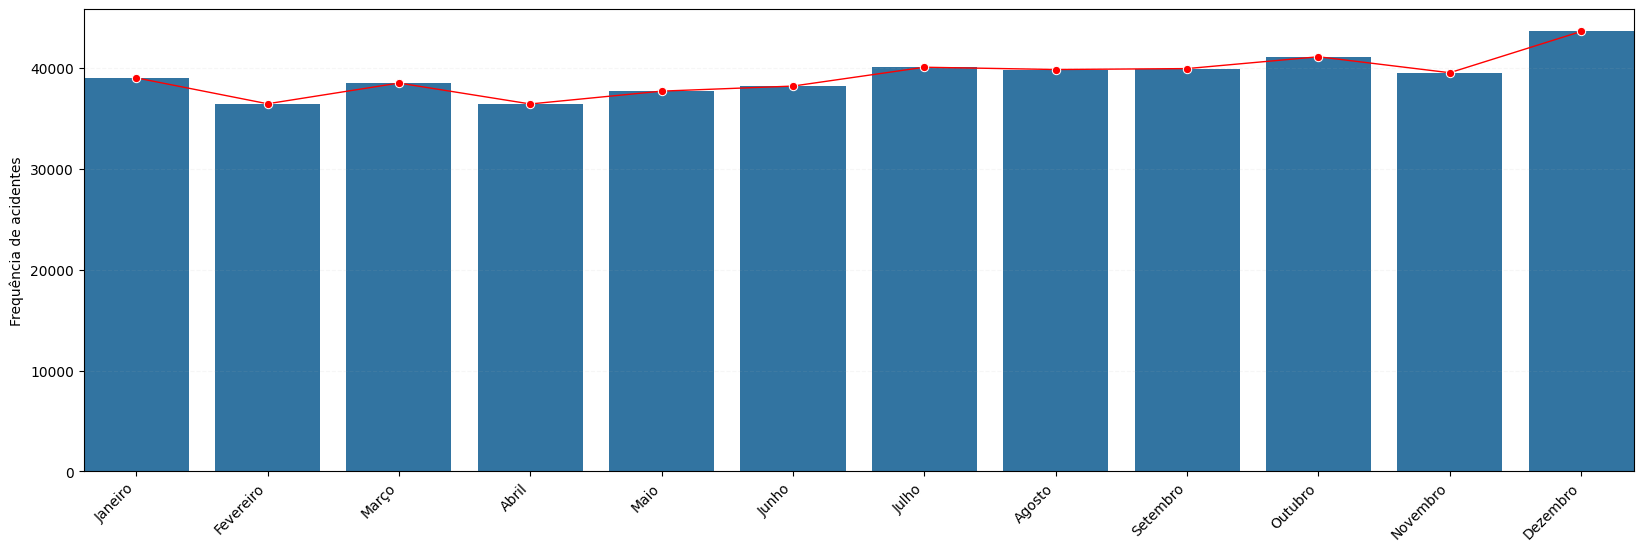

In [11]:
months, months_sorted = get_months()

df_accidents_new = df_accidents["mes"].value_counts().sort_index()
df_accidents_new.index = df_accidents_new.index.map(months)

# Convertendo o índice para categoria com a ordem correta
df_accidents_new.index = pd.Categorical(
    df_accidents_new.index, categories=months_sorted, ordered=True)

generate_barplot(
    enable_lineplot=True,
    x_value=df_accidents_new.index.astype(str),
    y_value=df_accidents_new.values,
    y_label="Frequência de acidentes",
    file_name="acidentes_por_mes_depois"
)